# Assigning Geometric Properties

Geometric properties refer to the physical sizes of the pores and throats, such as pore diameter and throat lengths. The values are essential to the pore network modeling enterprize since they control all the transport and percolation behavior of the network. Unlike phase properties which can be normalized for, geometric properties define the network even more so than topological properties like connectivity. 

Geometric properties *can* be calculated by various means, ranging from assigning random values to pores, extracting values from tomographic images. OpenPNM provides a library of functions, or 'pore-scale models' which can calcuate these geometric properties automatically. This tutorial will cover the following subjects:

| Subject |
| :- |
| Manually Calculating Pore and Throat Properties (⚠ Not Recommended!) |
| Using Pore-scale Models from the Library |
| Overview of the Dependency Handler |
| Using Predefined Collections of Models |
| Defining Heterogeneous Domains (by Applying Models to Specific Locations) |
| Customizing Models (by Overwriting Them or Their Arguments) |
| Writing and Using Custom Models |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import openpnm as op

Let's start by creating a blank Cubic network.  As we can see by printing it, there only coordinates, connections, and some labels, but no geometric properties:

In [2]:
np.random.seed(0)
pn = op.network.Cubic([20, 20, 20], spacing=5e-5)
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x214c26523b0>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coords                                                   8000 / 8000
  2  throat.conns                                                22800 / 22800
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.back                                                             400
  2  pore.bottom                                                           400
  3  pore.front                                                            400
  4 

.. attention:: Changed in V3

    In OpenPNM V3 we have removed the concept of ``Geometry`` and ``Physics`` objects, in favor of placing all the properties on the ``Network`` and ``Phase`` objects instead. 

To add geometrical properties to a network, we have a few different options.  Each will be explored below:

## Manually Calculating Properties

.. warning:: Manual Calculation is Not Recommended

    This is not the preferred way to do things, but does illustrate the processes very well. The preferred way is using pore-scale models, which allow for the automatic regeneration of dependent properities when something changes. 

Let's start by adding pore and throat size distributions.  There are a few different ways to do this, and we'll explore each one to be thorough.  

### Adding pore and throat sizes from `scipy.stats` distributions

Scipy's `stats` module has a *lot* of statistical distributions defined.  Let's generate pore and throat sizes using some of these.  First, let's use a normal distribution to generate pore sizes within the range ~1 to 50 um:

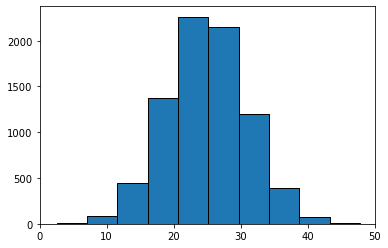

In [3]:
np.random.seed(0)
import scipy.stats as spst
psd = spst.norm.rvs(loc=25, scale=6, size=pn.Np)
plt.hist(psd, edgecolor='k')
plt.xlim([0, 50]);

The above distribution looks good, let's just make absolutely sure that our distribution is not so wide that it has negative numbers or values greater than 50 um:

In [4]:
print(psd.min())
print(psd.max())

2.5593961722893255
47.80996128980269


Now we'll convert these values to SI and assign to the network:

In [5]:
pn['pore.diameter'] = psd*1e-6  # um to m

Next we need to define throat diameters. We can do this in the same way, but let's use a different distribution.  Note that this approach is not recommended because as we'll see it results in throats that are larger than the two pores they are connected two.  We'll fix this in the following section:

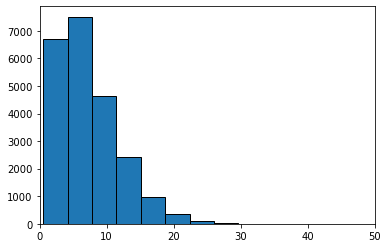

In [6]:
np.random.seed(0)
tsd = spst.weibull_min.rvs(c=1.5, loc=.5, scale=7.5, size=pn.Nt)
plt.hist(tsd, edgecolor='k')
plt.xlim([0, 50]);

Again, let's inspect the high and low values:

In [7]:
print(tsd.min())
print(tsd.max())

0.5130345457395142
36.96861960231873


So we can see that we have throats as small as 500 nm, and as large as 37 um.  These can be assigned to the network as well:

In [8]:
pn['throat.diameter'] = tsd*1e-6  # um to m

The problem with this approach is that both pore and throat sizes were just assigned to random locations, rather than putting small throats between small pores and vice-versa. When throats are larger than the pores they connect it can cause problems or strangeness in the results since we generally assume a throat is a constriction between two pores.  Let's count how many are problematic.

In [9]:
hits = np.any(pn['pore.diameter'][pn.conns].T < pn['throat.diameter'], axis=0)

In [10]:
hits.sum()

564

.. tip:: Indexing pore properties by `conns`
    
    Using the ``conns`` array to index into a pore property returns an Nt-by-2 array with the properties of the pores on the end of a throat in each column.  For instance, so see the diameter of the pore on each end of a throat, use ``pn['pore.diameter'][pn.conns]``.  This approach is very powerful.  If you ever feel tempted to use a for-loop to scan over each pore, then inspect the properties of the neighboring throats, consider instead if you can "loop" over the throats then interogate each pore.  If yes, then you can use this conns-indexing trick.

There are two *safer* ways to assign pore and throat sizes, to ensure that throats are smaller than the pores they connected.  The first is to proceed as above by assign pore sizes randomly, *then* assigning throats to be the *as small (or smaller) as the smallest pore it is connected to*.  This can be done using some `numpy` functions as follows:

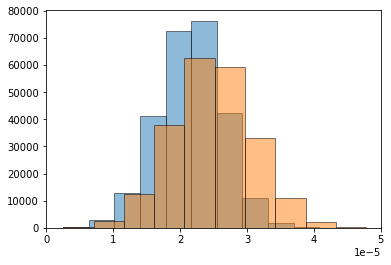

In [11]:
tsd = np.amin(pn['pore.diameter'][pn.conns], axis=1)
plt.hist(tsd, edgecolor='k', density=True, alpha=0.5)
plt.hist(pn['pore.diameter'], edgecolor='k', density=True, alpha=0.5)
plt.xlim([0, 50e-6]);

We can see from the above plot that the throat sizes are similar to the pore sizes, which is expected since they are taken from the pore sizes values. However, we can also see a small shift to the left, which is also expected given that the throats always take on the size of the smaller pore, creating a bias towards smaller sizes.

It may also be desirable to force the throats to be smaller than the two neighboring pores by some factor:

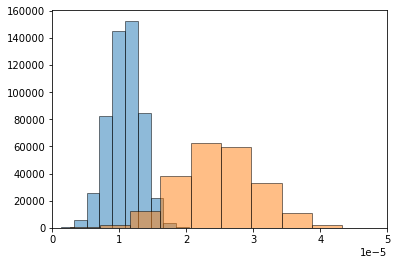

In [12]:
pn['throat.diameter'] = tsd*0.5
plt.hist(pn['throat.diameter'], edgecolor='k', density=True, alpha=0.5)
plt.hist(pn['pore.diameter'], edgecolor='k', density=True, alpha=0.5)
plt.xlim([0, 50e-6]);

One downside of the above approach is that you no longer have control over the shape and distribution of the throat sizes. This can be solved by applying the same approach just described but to random seeds instead of actual sizes. Then the random seeds can be put into a cumulative density function to compute the corresponding size.  This is demonstrated below:

In [13]:
lo, hi = 0.01, 0.99
pn['pore.seed'] = np.random.rand(pn.Np)*(hi - lo) + lo

.. tip::

    Setting the `lo` and `hi` values of the the seeds prevents values that lie far out in the tail of a distribution from occurring which can lead to overly large pores or throats.

The `ppf` function, or *point probability function* returns the value of a cumulative distribution at the given probability, so the seed values computed above can be related to size values using:

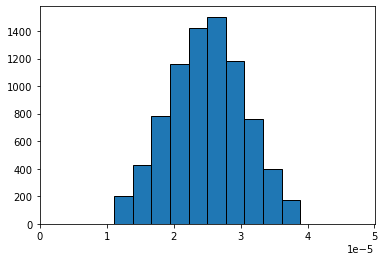

In [14]:
import scipy.stats as spst
psd = spst.norm.ppf(loc=25, scale=6, q=pn['pore.seed'])
pn['pore.diameter'] = psd*1e-6
plt.hist(pn['pore.diameter'], edgecolor='k')
plt.xlim([0, 50e-6]);

Now we can find the throat seed values as the *minimum pore seed* value of the two neighboring pores:

In [15]:
pn['throat.seed'] = np.amin(pn['pore.seed'][pn.conns], axis=1)

And then we can use these seed values in the `ppf` function of the desired distribution. So long as the distribution does not create larger values than the distribution used to compute pore sizes, then the throat sizes will always be smaller.

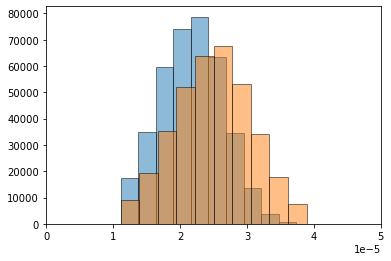

In [16]:
tsd = spst.norm.ppf(loc=25, scale=6, q=pn['throat.seed'])
pn['throat.diameter'] = tsd*1e-6
plt.hist(pn['throat.diameter'], edgecolor='k', density=True, alpha=0.5)
plt.hist(pn['pore.diameter'], edgecolor='k', density=True, alpha=0.5)
plt.xlim([0, 50e-6]);

Once the pore and throat diameters are specified, the next step is to define any dependent properties of interest, such as pore volume or throat length. These additional calculations tend to require that we assume a shape for the pores and throats.  It is not mandatory to use spheres and cylinders, though this is a common choice.  We could also work with cubic pores and cuboid throats, which occupy a large volume fraction for instance.  The choice of cubic shapes also happens to make the calculations much easier, for reasons explored below, so in this tutorial we'll assume cubic shapes.  Let's calculate the throat length, and pore surface area, since each of these illustrate very important concepts regarding the use of vectorized calculations.

### Computing throat length

Throat length is the pore-to-pore spacing, less the radius of each pore.  This can be found without the need for a for-loop using the following vectorization trick:

In [17]:
R1, R2 = (pn['pore.diameter'][pn.conns]/2).T
L_total = np.sqrt(np.sum(np.diff(pn.coords[pn.conns], axis=1).squeeze()**2, axis=1))
Lt = L_total - R1 - R2
print(L_total)

[5.e-05 5.e-05 5.e-05 ... 5.e-05 5.e-05 5.e-05]


The above cell contains 3 complicated but powerful steps:
1. The radii of the pores on each end of each throat are retrieved. `R1` and `R2` contain duplicates since each pore has numerous throats, so they appear once for each throat. This fact is used in step 3.
2. The pore-to-pore distance is found by retrieving the coordinates of each pore, in the same was as was done for the radii. The Euclidean distance between each pair of pores is then computed by finding their difference (`np.diff`), squaring it, summing it (`np.sum`), then taking the square root (`np.sqrt`) of each. The `axis` argument is used throughout to tell numpy which way to apply the operation. This line is an example of how you must learn a *mini-language* to use numpy effectively. 
3. The length of each throat is found as the spacing between pores, less the radii the pore on each end. This is where the duplicate values in `R1` and `R2` are necessary, since the radii of pore *i* must be subtracted from length of each of it's neighboring throats.

The main take-home message here is that throat properties can be computed in a vectorized way, even if some pore-properties are required. This avoids the use of a for-loop to scan through a list of throats followed by a nested for-loop to scan through each neighboring pore.

### Computing pore surface areas
The pore surface area is the total area of the cubic pore body, less the cross-sectional area of each neighboring throat. This can also be found without a for-loop, but requires knowing some deeper `numpy` functionality, known as [unbuffered in-place operations](https://numpy.org/doc/stable/reference/generated/numpy.ufunc.at.html):

In [18]:
At = pn['throat.diameter']**2
SAp = (pn['pore.diameter']**2)*6
np.subtract.at(SAp, pn.conns[:, 0], At)
np.subtract.at(SAp, pn.conns[:, 1], At)
print(SAp)

[9.08485305e-10 5.68134509e-09 2.33947201e-09 ... 6.57211706e-10
 1.92152447e-09 1.72429278e-09]


The above cell contains 2 lines of importance, which each do almost the same thing:
1. The first line subtracts the throat cross-sectional area from each pore listed in the first column of the `pn.conns` array. Since a given pore is connected to potentially many throats, the subtraction must be done using `np.substract.at` which is a special version of the subtract function that subtracts every value in `At` from the locations in `SAp` indicated by `pn.conn[:, 0]`, and it does so in a cumulative fashion. Thus if pore *i* appears in `pn.conns[:, 0]` more than once, then more than one value of `At` is removed. The operation is performed *in-place* so that no array is returned.
2. Recall that `pn.conns` contains only the upper-triangular entries of the adjacency matrix, so this process only gets half of the connections. This means that the pore connectioned found in `pn.conns[:, 1]` must also be analyzed.

## Using Pore-scale Models from the Library

The above section is quite lengthy, but lays bare the process of computing geometric properties of a network for illustration purposes.  In this section we'll utilize OpenPNM's library of 'pore-scale' models to get the same job done much more easily. Start by generating a fresh network:

In [19]:
np.random.seed(0)
pn = op.network.Cubic([20, 20, 20], spacing=5e-5)

First let's assign a random number to each pore, but instead of using `np.random.rand` directly, we'll use a pore-scale model:

In [20]:
f = op.models.geometry.pore_seed.random
pn.add_model(propname='pore.seed', 
             model=f,
             seed=None,  # Seed value provided to numpy's random number generator.
             num_range=[0.01, 0.99],)

.. note:: Where do models go?

    We'll look more closely at models later in this tutorial, but it's worth pointing out that the `add_model` method collects all the arguments provided and stores them in the `models` attribute of the object. Later, when `regenerate_models` is called, it looks into the `models` attribute and fetches the model (`f`) and the given arguments, calls the function, collects the returned result, and stores them in `pn[propname]`. You can see a list of models applied to the object with `print(pn.models)`. 

Let's have each throat inherit the minimum seed value found in each of its neighboring pores, for which OpenPNM provides a model:

In [21]:
f = op.models.geometry.throat_seed.from_neighbor_pores
pn.add_model(propname='throat.seed', 
             model=f,
             prop='pore.seed',
             mode='min')

.. tip:: Using shift-tab to see the docstring

    In the above two code blocks the models were assigned to `f` first, then `f` was passed to the `model` argument. This is helpful for two reasons.  (1) It helps keep the line length below Python's preferred limit of 78 characters, and (2) it makes it possible to see the docstring of the model by putting the cursor at the end of the first line and hitting `shift-tab`. Seeing the docstring really helps to understand what a model does and what arguments are required.

Now we can compute pore and throat sizes from distributions, which are also provided as OpenPNM models:

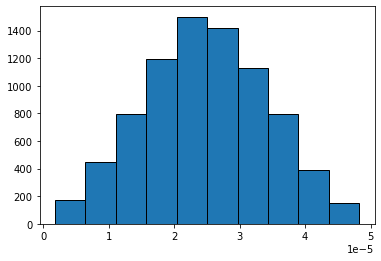

In [35]:
f = op.models.geometry.pore_size.normal
pn.add_model(propname='pore.diameter',
             model=f,
             scale=1e-5, 
             loc=2.5e-5,
             seeds='pore.seed')
plt.hist(pn['pore.diameter'], edgecolor='k');

And similarly we fetch a model for the throat sizes as well:

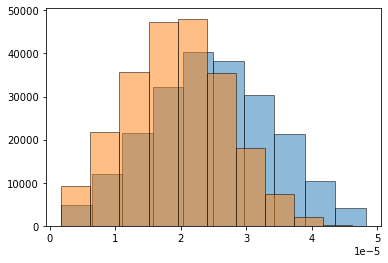

In [36]:
f = op.models.geometry.throat_size.normal
pn.add_model(propname='throat.diameter',
             model=f,
             scale=1e-5, 
             loc=2.5e-5)
plt.hist(pn['pore.diameter'], edgecolor='k', density=True, alpha=0.5)
plt.hist(pn['throat.diameter'], edgecolor='k', density=True, alpha=0.5);

Now that we have pore and throat sizes, we can compute their volumes (and other properties). The volume will depend on the shape of the pores and throats.  In OpenPNM we do not explicitly track such *shapes*.  Instead we offer several models that calculate the property of interest for a given shape. This is illustrated below:

In [37]:
f = op.models.geometry.throat_length.spheres_and_cylinders
pn.add_model(propname='throat.length',
             model=f)
f1 = op.models.geometry.pore_volume.sphere 
pn.add_model(propname='pore.volume',
             model=f1)
f2 = op.models.geometry.throat_volume.cylinder
pn.add_model(propname='throat.volume',
             model=f2)

.. warning:: Spherical pores overlap with their throats
    
    A spherical pore will always have a region of overlap with it's connected throats. The volume of this region will be double counted if an extra step is not taken. 

In [38]:
f = op.models.geometry.throat_length.spheres_and_cylinders
pn.add_model(propname='throat.length',
             model=f)
f1 = op.models.geometry.pore_volume.sphere 
pn.add_model(propname='pore.volume',
             model=f1)
f2 = op.models.geometry.throat_volume.cylinder
pn.add_model(propname='throat.total_volume',
             model=f2)
f3 = op.models.geometry.throat_volume.lens
pn.add_model(propname='throat.lens_volume',
             model=f3)
f4 = op.models.misc.difference
pn.add_model(propname='throat.volume',
             model=f4,
             props=['throat.total_volume', 'throat.lens_volume'])

We can inspect some of these values to make sure they are making sense:

In [42]:
print("Volumes of full throats:", pn['throat.total_volume'][:3])
print("Volumes of lenses:", pn['throat.lens_volume'][:3])
print("Actual throat volumes:", pn['throat.volume'][:3])

Volumes of full throats: [1.70606123e-14 1.49642200e-14 8.56617280e-15]
Volumes of lenses: [4.30295464e-15 3.70683677e-15 1.60690817e-15]
Actual throat volumes: [1.27576577e-14 1.12573832e-14 6.95926463e-15]


## Using Predefined Collections of Models

The process of selecting all the correct models from the `models` library can be tedious and error prone. In OpenPNM V3 we have introduced the concept of model *collections*, which are predfined dictionaries of models that form a complete and correct geometry. For instance, there is a collection called `spheres_and_cylinders`, which contains all the needed models to describe this geometry.  

These collections are found under `openpnm.models.collections`, and their use is outlined below:

In [52]:
pn = op.network.Cubic(shape=[20, 20, 20], spacing=5e-5)

The models *collection* is fetched as follows:

In [53]:
mods = op.models.collections.geometry.spheres_and_cylinders
print(mods)

{'pore.seed': {'model': <function random at 0x00000214C12504C0>, 'element': 'pore', 'num_range': [0.2, 0.7], 'seed': None}, 'pore.max_size': {'model': <function largest_sphere at 0x00000214C21D0EE0>, 'iters': 10}, 'pore.diameter': {'model': <function product at 0x00000214C1250DC0>, 'props': ['pore.max_size', 'pore.seed']}, 'pore.volume': {'model': <function sphere at 0x00000214C21D6550>, 'pore_diameter': 'pore.diameter'}, 'throat.max_size': {'model': <function from_neighbor_pores at 0x00000214C125F160>, 'mode': 'min', 'prop': 'pore.diameter'}, 'throat.diameter': {'model': <function scaled at 0x00000214C1250E50>, 'factor': 0.5, 'prop': 'throat.max_size'}, 'throat.length': {'model': <function spheres_and_cylinders at 0x00000214C21F58B0>, 'pore_diameter': 'pore.diameter', 'throat_diameter': 'throat.diameter'}, 'throat.cross_sectional_area': {'model': <function cylinder at 0x00000214C21D6E50>, 'throat_diameter': 'throat.diameter'}, 'throat.volume': {'model': <function cylinder at 0x0000021

The print-out of the dictionary is not very nice, but it can be seen that the keys are the model names, and the values are the model itself and the various arguments for the model.  This dictionary can be added to the network using the `add_models_collection` method as follows:

In [54]:
pn.add_model_collection(mods)
pn.regenerate_models()
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x214c5c05c70>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coordination_number                                      8000 / 8000
  2  pore.coords                                                   8000 / 8000
  3  pore.diameter                                                 8000 / 8000
  4  pore.max_size                                                 8000 / 8000
  5  pore.seed                                                     8000 / 8000
  6  pore.volume                                                   8000 / 8000
  7  throat.conns                                                22800 / 22800
  8  throat.cross_sectional_area                                 22800 / 22800
  9 

## Customizing Models by Overwriting Them or Their Arguments

The pre-written models and collections included with OpenPNM are helpful, but you'll almost always want to adjust some of the models to suit a specific application. This can be done by either altering the arguments of existing models, or by overwriting them all together. 

Let's first look at replacing a model with one of our choice.  The `spheres_and_cylinders` collection uses a random distribution of pore sizes, bounded between 0 and the distance to the nearest neighbor. This can be inspected by printing the specific model as follows:

In [55]:
print(pn.models['pore.diameter@all'])

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Property Name             Parameter                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
pore.diameter             model:                    product
                          props:                    ['pore.max_size', 'pore.seed']
                          regeneration mode:        deferred
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


.. note:: The @ Notation

    The @all that has been added to the model name is new in Version 3 and means that this model should be applied to pore that have the label `'pore.all'`. This will be explained in detail in the next tutorial. 

Let's replace this with a normal distribution. This can be done with the `add_model` method as before. 

In [56]:
f = op.models.geometry.pore_size.normal
pn.add_model(propname='pore.diameter',
             model=f,
             scale=1e-5, 
             loc=2.5e-5,
             seeds='pore.seed')

Now print the model again to ensure it was updated:

In [57]:
print(pn.models['pore.diameter@all'])

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Property Name             Parameter                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
pore.diameter             model:                    normal
                          scale:                    1e-05
                          loc:                      2.5e-05
                          seeds:                    pore.seed
                          regeneration mode:        normal
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


And let's inspect the values:

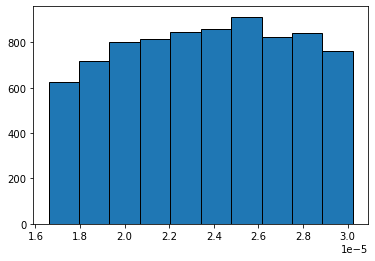

In [59]:
plt.hist(pn['pore.diameter'], edgecolor='k');

This distribution is quite truncated, due to the `'pore.seed'` values that were used.  Let's reach into that model and change this.  First print the model:

In [60]:
print(pn.models['pore.seed@all'])

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Property Name             Parameter                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
pore.seed                 model:                    random
                          element:                  pore
                          num_range:                [0.2, 0.7]
                          seed:                     None
                          regeneration mode:        deferred
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


We can see that the `num_range` argument is quite constrained, so let's change it. Each model is itself a dictionary, so we can overwrite as follows:

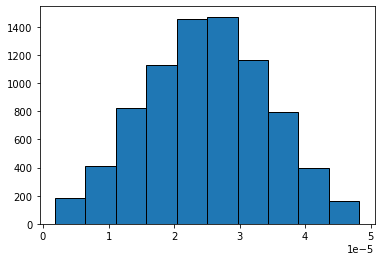

In [61]:
pn.models['pore.seed@all']['num_range'] = [0.01, 0.99]
pn.regenerate_models()
plt.hist(pn['pore.diameter'], edgecolor='k');

## Introduction to the Dependency Handler

Pore-scale models clearly make life easier since you don't have to produce the complex numpy functions by hand each time, but this is not even their best feature. The main benefit of pore-scale models is that they can be *recomputed* automatically. For instance, if we re-run the `'pore.seed'` model, then all the other models that depend on `'pore.seed'` will automatically be reomcomputed as well. This all occurs when we call `regenerate_models`, as demonstrated below:

In [66]:
pn = op.network.Cubic(shape=[20, 20, 20], spacing=5e-5)
pn.add_model(propname='pore.seed',
             model=op.models.geometry.pore_seed.random)
pn.add_model(propname='pore.diameter',
             model=f,
             scale=1e-5, 
             loc=2.5e-5,
             seeds='pore.seed')
pn.add_model(propname='throat.seed',
             model=op.models.geometry.throat_seed.from_neighbor_pores,
             prop='pore.seed')
pn.add_model(propname='throat.diameter',
             model=f,
             scale=1e-5, 
             loc=2.5e-5,
             seeds='throat.seed')
print(pn['pore.seed'])
print(pn['throat.diameter'])

[0.93922037 0.61280983 0.92348118 ... 0.70619142 0.39657606 0.66479834]
[2.78664997e-05 2.78664997e-05 1.19060194e-05 ... 2.75050628e-05
 2.23778038e-05 2.92559453e-05]


In [67]:
pn.regenerate_models()
print(pn['pore.seed'])
print(pn['throat.diameter'])

[0.0827237  0.85042386 0.99185044 ... 0.40135846 0.82144676 0.48632003]
[1.11301848e-05 3.53825302e-05 1.97664028e-05 ... 2.25016755e-05
 2.11391399e-06 2.46570267e-05]


As we can see above the initial values of `'pore.seed'` and `'throat.diameter'` are both changed after calling `regenerate_models()`. OpenPNM does this automaticall by inspecting the arguments to each function. 

Inspecting the `add_model` calls above we can see:

1. The `'throat.seed'` model takes `'pore.seed'` as an argument
2. The `'throat.diameter'` model takes `'throat.seed'` as an argument
3. The `'pore.diameter'` models takes `'pore.seed'` as an argument

So when `regenerate_models` is called it first re-runs the `'pore.seed'` model, which has no dependencies, then it re-runs the `'throat.seed'` model, then `'throat.diameter'`, in that order based on their dependencies. It also calls `'pore.diameter'`, but no other models depend on this. The dependency handling is done by creating a graph or network using `networkx` then do a special sort to find the top of the tree and all the downstream dependencies.  This can be roughly visualized using:

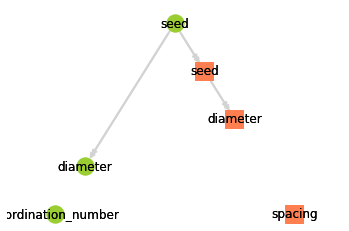

In [68]:
pn.models.dependency_map(style='planar');

The green circles are pore properties and the orange squares are throat properties. We can also see that there are two models which are not dependent on anything else: `'throat.spacing'` and `'pore.coordination_number'`.  These are added to all networks during generation but not run, hence their values do no show up when doing `print(pn)`.

It is also possible to make your own plot if you wish, by retrieving the dependency graph then calling the `networkx` plotting function of your choice:

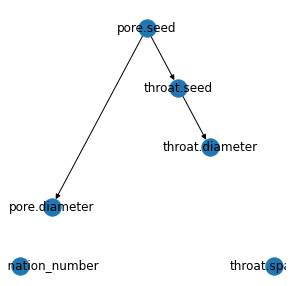

In [69]:
import networkx as nx
g = pn.models.dependency_graph()
fig, ax = plt.subplots(figsize=[5, 5])
nx.draw_networkx
nx.draw_planar(g, labels={k: k for k, v in g.nodes.items()}, ax=ax)